
## Hands on Machine Learning chapter 05 실습
Support Vector Machine - support vector기반의 선형 및 비선형 분류 및 회귀 모델

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 라지 마진 분류

In [ ]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM 분류 모델
# SVC --> libsvm, LinearSVC --> liblinear
# libsvm : OvO 전략 지원
# liblinear: OvR 지원
# SVC: 비선형/선형 모델 지원, 힌지 손실함수 사용 (SVC(kernel='linear'))
# LinearSVC: 선형 모델 지원 'squared hinge' 손실함수 사용
svm_clf = SVC(kernel="linear", C=float("inf"))
# C: 규제 제어, 
# C값이 클수록 규제가 작아짐 (alpha와는 반대임. inverse regularization이라 할수있음)
# C값이 무한대이면, 규제가 거의 없는 방식임을 의미
svm_clf.fit(X, y)

SVC(C=inf, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

그림 저장: large_margin_classification_plot


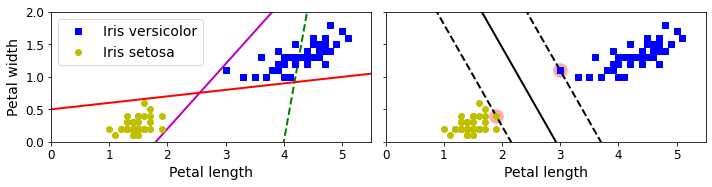

In [ ]:
# 나쁜 모델
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    
    # 이부분은 이론에서 자세히
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    
    # 두 클래스의 경계 사이가 가장 넓은 폭을 찾는 알고리즘 --> 서포트 백터(샘플)가 결정한다
    # 어떤 샘플이 경계를 결정하는데에 결정적인 역할을 함
    # 실제 support vector안에 담긴 샘플들을 graph해보면 다음과 같음.
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

# 오른쪽 graph에 support vector의 샘플을 marking함
# SVM: 가장 넓은 도로의 폭을 찾는 알고리즘이라 할 수 있음(마진이 가장 큰: "라지 마진 분류")
# 중앙에있는 solid line이 "결정 경계"

# 특성의 스케일에 민감함

그림 저장: sensitivity_to_feature_scales_plot


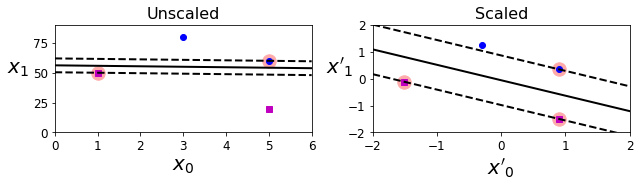

In [ ]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
# 데이터를 변환하지않고 훈련
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
# 데이터를 변환하고 훈련 (특성을 표준화 전처리 함)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x'_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")
# ==> lesson learned: SVM은 반드시 특성 표준화 전처리를 해야한다

# 이상치에 민감함

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


그림 저장: sensitivity_to_outliers_plot


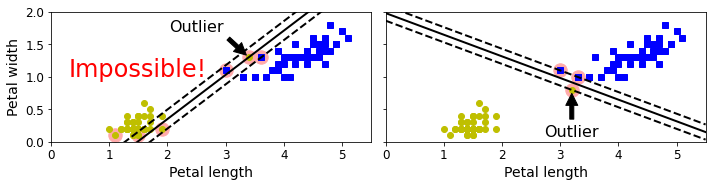

In [ ]:
# 이상치를 임의로 추가
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

svm_clf_imp = SVC(kernel='linear', C=np.inf, max_iter=100)
# max_iter = -1 default임. 이런 경우 결과가 출력되지않고 계속 실행만 될것임. 100수준으로 제한해야함
svm_clf_imp.fit(Xo1, yo1)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plot_svc_decision_boundary(svm_clf_imp, 0, 5.5)

plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()
# 첫번째 graph: 결정경계 그리기 불가함


# 라지 마진 vs 마진 오류

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica인지 구분하는 이진분류로 실습

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [ ]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

여러가지 규제 설정 비교

In [ ]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=100, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [ ]:
# 스케일되지 않은 파라미터로 변경 (원본데이터셋 scale에 맞도록 모델의
#                                 coefficient, intercept를 보정한것임)
# z = (x - mean) / std
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_

svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않습니다.)
# 힌지손실 max(0, 1-t*y) 
#                         t*y > 1 --> 음수--> 손실함수 값: 0
#                         t*y > 1 --> 양수 --> 손실함수 값:1-t*y
# t(target)은 1 or -1
# y는 결정함수 값(가중치와 절편을 사용해서 계산한 값)

# 손실함수 값 최소화? 0을 언제 갖는지?
# y > 1 (t가 양성인경우) or y < -1(t가 음성인경우)  ==> 즉, |y| > 1

# targetvs. label 혼돈하지 마라! 
# 같은 logsitic 회귀를 뜻하지만, [0,1] --> [-1,1]로 변경한 다른 모양의 공식일뿐이다.

# 데이터셋에서 target값으로는 y = 0 or 1
t = y * 2 - 1
# t=[-1,1]를 만들기위해 위 공식 적용함
# 참고: sklearn의 SVC/ LinearSVC를 사용하면, y=[0,1]을 넣어도 자동으로 t=[-1,1]로 만들어준다
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

그림 저장: regularization_plot


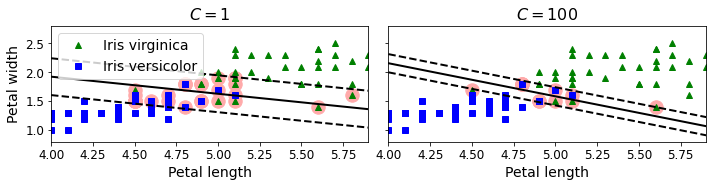

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")
# ==> C=1 규제가 세면, 더 단순한 모델이 만들어지고, 더 많은 오류값들이 확인된다.

# 비선형 분류

그림 저장: higher_dimensions_plot


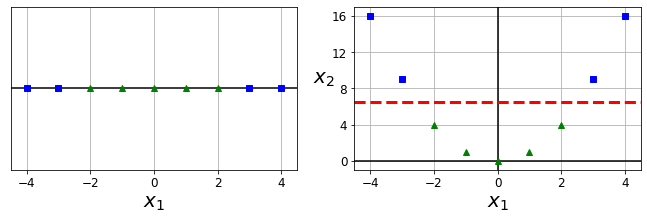

In [ ]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
# 양성(초록 삼각형), 음성(파란 네모) 나누어서 그림
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()
# polynomial featurers랑 동일한 작업임.
# 다항 특성을 만들어서 분류 작업을 함.

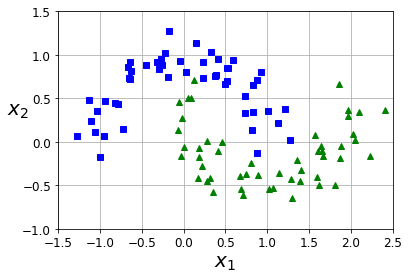

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
# make_moons : 반달모양의 데이터 셋 샘플들 생성

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [ ]:
# LinearSVC: liblinear (C library) 사용 libsvm을 개선하기위해 만들어진게 liblinear
#            선형 문제를 풀때에 다차원(커널)을 사용하지 말고 간단하게 선형으로
#            빠르게 문제를 해결하기위해 만들어 진것이 liblinear임.
#            더 고급형 - 특성이 많은 경우에도 선형으로 빠르게 분류작업 가능
#            좌표경사법 - coordinate descent + 뉴튼 메서드
#            C 사용: C를 늘리면 복잡한 모델, 훈련시간이 늘어난다.
#            LogisticRegression(solver = 'liblinear')
#            LogisticRegression(solver = 'lbfgs') < - 0.2버전이후? lbfgs가 default임
# SVC : libsvm library, kernel 함수 사용. text 분류작업에 많이 사용되었음.
#       보편적

from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# liblinear은 절편도 규제에 포함한다. 그래서 stdscaler 처리가 필요함
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42)) #default가 sq. hinge이기때문에 따로 표기필요
    ])

polynomial_svm_clf.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

그림 저장: moons_polynomial_svc_plot


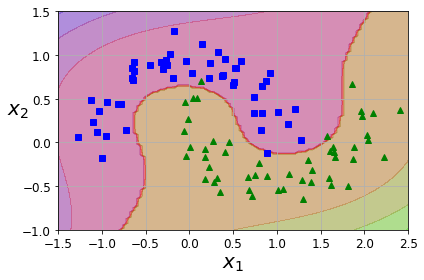

In [ ]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s) #2D 좌표 평면에있는 모든 좌표값get
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.3) 
    #contourf()의 alpha값을 높이면 contour경계 더 뚜렷히 보인다

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()
# ==> 특성이 많고, 데이터셋 샘플수도 많은 경우 LinearSVC를 사용하면 더 빠르게 결과 도출가능

In [ ]:
# 특성의 갯수가 많지않은 경우, SVC를 사용
# kernel tree - polynomial features를 만들지 않고도 비슷한 효과
# kernel = "poly"
# (gamma * <x, x'> + coef0)^degree
# gamma = 'scale' : gamma의 기본값 = 1/(특성개수*데이터의분산)

from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=100, decision_function_shape='ovr', degree=10,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

그림 저장: moons_kernelized_polynomial_svc_plot


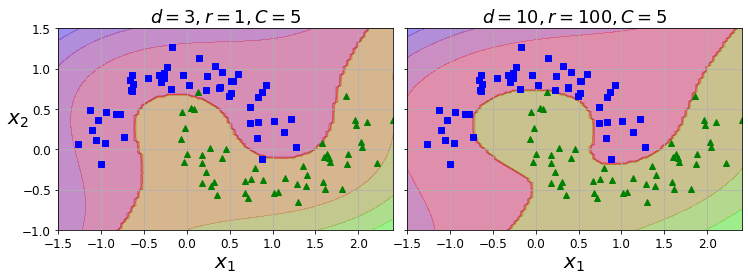

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()
# ==> 고차항이 10일때에 3일때보다 더 복잡한 결정경계가 만들어짐

**식 5-1: 가우시안 RBF**

$
{\displaystyle \phi_{\gamma}(\mathbf{x}, \boldsymbol{\ell})} = {\displaystyle \exp({\displaystyle -\gamma \left\| \mathbf{x} - \boldsymbol{\ell} \right\|^2})}
$


exp(v) : v<0인 경우 exp(v)는 0과 1 사이이다.

v << 0 인 경우(매우 큰 음수) 0에 가까워짐. (x와 l 사이 차이가 큰 경우) 아주 멀리있는 샘플일수록 영향이 더 작다.

v < 0 인 경우(작은 음수) 1에 가까워짐 (x와 l이 가까운 경우)

그림 저장: kernel_method_plot


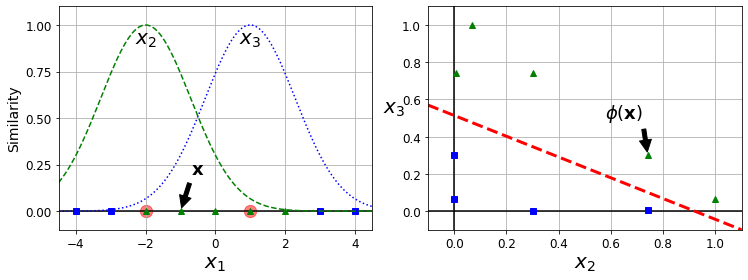

In [ ]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
# 200개의 point와 -2와의 관계(gaussian kernel)
x2s = gaussian_rbf(x1s, -2, gamma) 
# 200개의 point와 1와의 관계(gaussian kernel)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()
# ==> 샘플간의 유사도를 확인할 수 있고 (여기서 지정한 landmark(l)은 -2와 1이고
#         각 샘플(x)가 landmark와 얼마나 떨어져있는지를 이수함수(exp)의 특성을 사용해서
#         값을 도출하여 샘플간의 유사도를 확인 한 것이다)
#     비선형적인 데이터 셋을 바탕으로 선형경게를 그릴수있다

In [ ]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


In [ ]:
# SVC coef_ 존재하지 않는다.
# 나와 다른 모든 다른 샘플들간의 유사도를 확인한다.

rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
# kernel="rbf" 
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

그림 저장: moons_rbf_svc_plot


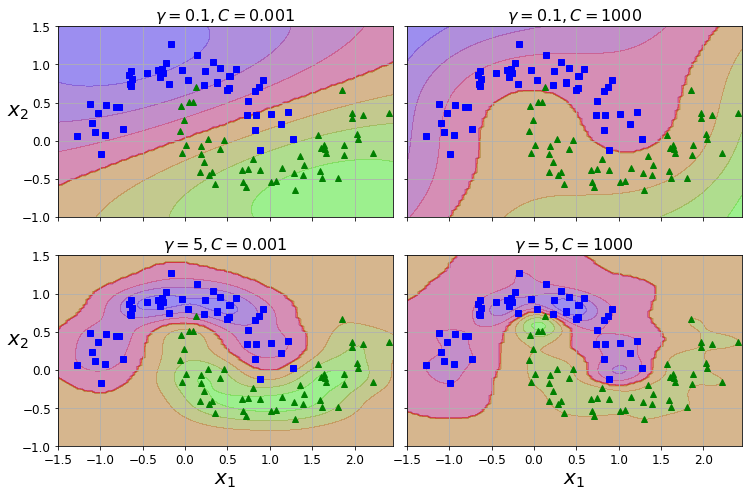

In [ ]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()
# 규제 variation: 규제가 많이 주어지면 더 단순한 모델, 규제가 작으면 더 복잡한 모델 구현
# gmma variation: 동일한 규제에서 gamma값이 크면 kernel 함수의 출력값이 줄어든
#  (아주 인접한 샘플에만 영향을 미친다.) -> 더 복잡한 모델이 만들어진다.

# 회귀

In [ ]:
# 분류: 최대 마진
# 회귀: 마진안에 포함

np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [ ]:
# LinearSVR vs. SVR
# 도로의 폭: epsilon
# 회귀 모델의 손실 함수: max(0, |y-y_hat|-epsilon)
# |y-y_hat|< epsilon 경우이면 손실함수=0 (도로폭 안에 들어옴)

from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [ ]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

# LinearSVR은 support vector 샘플들을 찾아주지는 않음. 
# 마진 밖에있는 샘플들을 수동으로 찾음
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon) #'도로 밖'으로 나간 값
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

그림 저장: svm_regression_plot


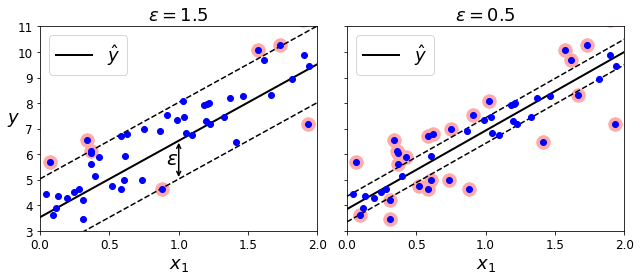

In [ ]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--") # 결정경계 위 선
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--") # 결정경계 아래 선
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

# ==> 일반적으로 회귀문제인 경우 결정 함수를 직접 그려서 결과를 확인한다.
# ==> 분류인 경우에는 결정함수 값을 직접 그릴 필요는 없고, 결정 함수가 샘플과 만나느
# 결정 경계만 표시하면 됨. 특성(x1, x2)를 사용해서 예시를 보여준다.

In [ ]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

**노트**: 향후 버전을 위해 사이킷런 0.22에서 기본값이 될 `gamma="scale"`으로 지정했습니다.

In [ ]:
from sklearn.svm import SVR
# kernel="poly" : 다항 kernel을 사용한다
# gamma = "scale" 무슨뜻이였지?
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
# 비선형 데이터 회귀를 위해  SVR
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

그림 저장: svm_with_polynomial_kernel_plot


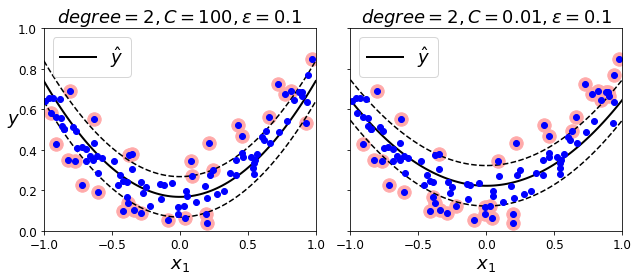

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
# plot_svm_regression를 사용해서 graph 그린다
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

# epsilon값이 특성값에 따라서 미치는 영향이 달라짐
# 도로의 폭이 넓어지고, 좁아지는 영향 (SVR의 특징중 하나이다)

# SVM 이론

**식 5-2: 선형 SVM 분류기의 예측**

$
\hat{y} = \begin{cases}
 0 & \mathbf{w}^T \mathbf{x} + b < 0 \text{ 일 때}, \\
 1 & \mathbf{w}^T \mathbf{x} + b \geq 0 \text{ 일 때}
\end{cases}
$

In [ ]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

그림 저장: iris_3D_plot


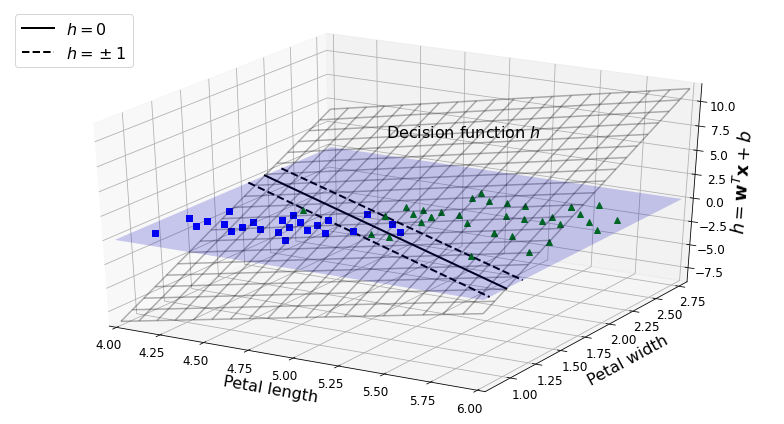

In [ ]:
# hinge 손실 함수 = max(0, 1-t*y) <-- |y|>1 조건에서 손실 0

from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    # 결정경계 그리기
    # 결정함수: y = x1s*w[0] + x2s*w[1] + b
    # 결정경계는: 0 = y = x1s*w[0] + x2s*w[1] + b
    # 결정 경계 마진경계:   1 = x1s*w[0] + x2s*w[1] + b
    #                      -1 = x1s*w[0] + x2s*w[1] + b
    # decision function plane이 누울수록, 마진값이 더 넓어진다.
    # 목표 - 마진을 더 넓게 (도로의 폭을 넓게) 하기위해 decision function plane이 더 '누워'있어야함
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

save_fig("iris_3D_plot")
plt.show()

# 작은 가중치 벡터가 라지 마진을 만듭니다

그림 저장: small_w_large_margin_plot


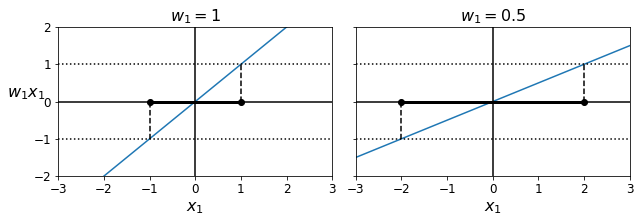

In [ ]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()
# y-축: 결정함수
# x-축: 특성
# w(가중치) 값이 줄어들면 1 --> 0.5, 특성공간에서의 마진이 더 커진다는것이 확인된다.

In [ ]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64) # Iris virginica

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)
svm_clf.predict([[5.3, 1.3]])

array([1.])

#### 하드 마진

l2 norm:
||w|| =  sqrt(w1^2 + w2^2)
||w||^2 = w1^2 + w2^2

1-t*y < 0 목표

1 < t*y 모든 샘플이 도로 경계 밖에 위치야하는 조건



**식 5-3: 하드 마진 선형 SVM 분류기 목적 함수**

$
\begin{split}
&\underset{\mathbf{w}, b}{\operatorname{minimize}}\quad{\frac{1}{2}\mathbf{w}^T \mathbf{w}} \\
&\text{subject to} \quad t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) \ge 1 \quad \text{for } i = 1, 2, \dots, m
\end{split}
$

#### 소프트 마진

일부 샘플이 도로의 폭안에 포함되어도 괜찮다.
zeta (slack변수)   <-- 규제의 역할

**식 5-4: 소프트 마진 선형 SVM 분류기 목적 함수**

$
\begin{split}
&\underset{\mathbf{w}, b, \mathbf{\zeta}}{\operatorname{minimize}}\quad{\dfrac{1}{2}\mathbf{w}^T \mathbf{w} + C \sum\limits_{i=1}^m{\zeta^{(i)}}}\\
&\text{subject to} \quad t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) \ge 1 - \zeta^{(i)} \quad \text{and} \quad \zeta^{(i)} \ge 0 \quad \text{for } i = 1, 2, \dots, m
\end{split}
$

LinearSVC dual = True (좌표경사법 사용) /False (뉴턴 메서드 사용, 원문제도 해결 가능)

SVC / SVR (커널 크릭 사용) 쌍대 문제만을 푼다

**식 5-8: 2차 다항식 매핑**

$
\phi\left(\mathbf{x}\right) = \phi\left( \begin{pmatrix}
  x_1 \\
  x_2
\end{pmatrix} \right) = \begin{pmatrix}
  {x_1}^2 \\
  \sqrt{2} \, x_1 x_2 \\
  {x_2}^2
\end{pmatrix}
$


**식 5-9: 2차 다항식 매핑을 위한 커널 트릭**

커널크릭 - 특성 갯수를(특성 공간을) 늘리지 않더라도 같은 효과가 있다.

$
\begin{split}
\phi(\mathbf{a})^T \phi(\mathbf{b}) & \quad = \begin{pmatrix}
  {a_1}^2 \\
  \sqrt{2} \, a_1 a_2 \\
  {a_2}^2
  \end{pmatrix}^T \begin{pmatrix}
  {b_1}^2 \\
  \sqrt{2} \, b_1 b_2 \\
  {b_2}^2
\end{pmatrix} = {a_1}^2 {b_1}^2 + 2 a_1 b_1 a_2 b_2 + {a_2}^2 {b_2}^2 \\
 & \quad = \left( a_1 b_1 + a_2 b_2 \right)^2 = \left( \begin{pmatrix}
  a_1 \\
  a_2
\end{pmatrix}^T \begin{pmatrix}
    b_1 \\
    b_2
  \end{pmatrix} \right)^2 = (\mathbf{a}^T \mathbf{b})^2
\end{split}
$

**식 5-10: 일반적인 커널**

$
\begin{split}
\text{선형:} & \quad K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \mathbf{b} \\
\text{다항식:} & \quad K(\mathbf{a}, \mathbf{b}) = \left(\gamma \mathbf{a}^T \mathbf{b} + r \right)^d \\
\text{가우시안 RBF:} & \quad K(\mathbf{a}, \mathbf{b}) = \exp({\displaystyle -\gamma \left\| \mathbf{a} - \mathbf{b} \right\|^2}) \\
\text{시그모이드:} & \quad K(\mathbf{a}, \mathbf{b}) = \tanh\left(\gamma \mathbf{a}^T \mathbf{b} + r\right)
\end{split}
$

규제는 penalty 파라미터로 설정한다.

LinearSVC(penalty='l2')

LinearSVC(penalty='l1')

**식 5-13: 선형 SVM 분류기의 비용 함수**

$
J(\mathbf{w}, b) = \dfrac{1}{2} \mathbf{w}^T \mathbf{w} \,+\, C {\displaystyle \sum\limits_{i=1}^{m}max\left(0, t^{(i)} - (\mathbf{w}^T \mathbf{x}^{(i)} + b) \right)}
$

# 힌지 손실

그림 저장: hinge_plot


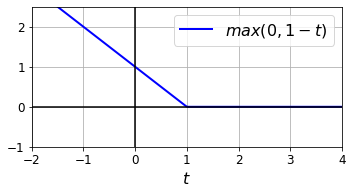

In [ ]:
t = np.linspace(-2, 4, 200) # 노트: t*y 대신 그냥 변수 t로 graph함
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
save_fig("hinge_plot")
plt.show()

## 훈련 시간

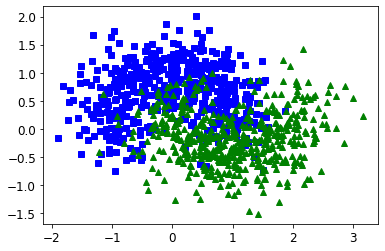

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

[LibSVM]0 0.1 0.3670499324798584
[LibSVM]1 0.01 0.3704507350921631
[LibSVM]2 0.001 0.4446096420288086
[LibSVM]3 0.0001 0.9659416675567627
[LibSVM]4 1e-05 2.1397550106048584
[LibSVM]5 1.0000000000000002e-06 1.8944087028503418
[LibSVM]6 1.0000000000000002e-07 13.99381971359253
[LibSVM]7 1.0000000000000002e-08 1.7516014575958252
[LibSVM]8 1.0000000000000003e-09 1.672881841659546
[LibSVM]9 1.0000000000000003e-10 1.7432475090026855


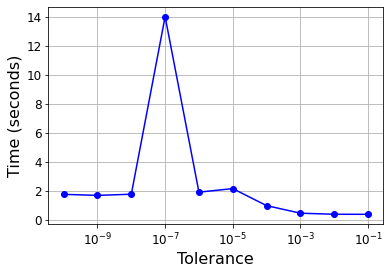

In [ ]:
import time

tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10
plt.semilogx(tols, times, "bo-")
plt.xlabel("Tolerance", fontsize=16)
plt.ylabel("Time (seconds)", fontsize=16)
plt.grid(True)
plt.show()

## 배치 경사 하강법을 사용한 선형 SVM 분류기 구현

In [ ]:
# 훈련 세트
X = iris["data"][:, (2, 3)] # # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris virginica

In [ ]:
# LinearSVC 직접 구현해보기 코드:

from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    # eta값을 점점 줄이는 함수 (학습률 수렴하며 진행하도록)
    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if t==0, +1 if t==1
        # 1 - t*(w*x + b)
        # 1 - tx * w - t*b
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            # support vector 샘플 구하기
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)
            # - tx 
            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -self.C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[1.],
       [0.]])

(0.0, 60000.0, 0.0, 100.0)

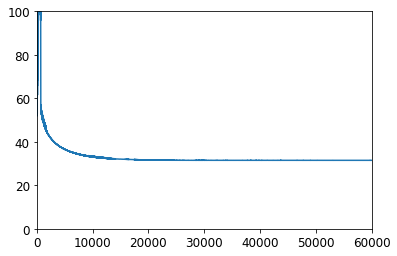

In [ ]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [ ]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


In [ ]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


(4.0, 6.0, 0.8, 2.8)

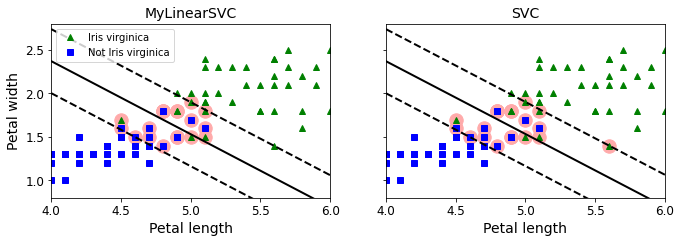

In [ ]:
yr = y.ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")

plt.sca(axes[1])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


[-12.52988101   1.94162342   1.84544824]


(4.0, 6.0, 0.8, 2.8)

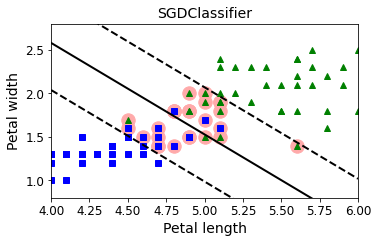

In [ ]:
# SGDClassifier도 loss="hinge"로 설정하여 유사한 결과 얻을 수 있다

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # t==0이면 -1, t==1이면 +1
X_b = np.c_[np.ones((m, 1)), X]  # 편향 x0=1을 추가합니다
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
